In [1]:
import os
os.chdir('/home/ron/Documents/DenseSeg')
print(os.getcwd())

from dataset.jsrt_dataset import JSRTDataset, TRAINING_SHAPES
from matplotlib import pyplot as plt

from inverse_grid_sample import *
from scipy.interpolate import griddata


/home/ron/Documents/DenseSeg


In [20]:
print(sample)

tensor([[114.7500, 181.7500],
        [109.7500, 170.0000],
        [106.7500, 158.2500],
        [107.7500, 146.5000],
        [111.2500, 134.7500],
        [116.7500, 123.0000],
        [122.8215, 117.1785],
        [128.8927, 112.7500],
        [134.9642, 110.0358],
        [141.0358, 107.7500],
        [147.1073, 106.0000],
        [153.1785, 105.0000],
        [159.2500, 104.5000],
        [171.3750, 119.1250],
        [182.0000, 133.7500],
        [192.6250, 148.3750],
        [198.2500, 163.0000],
        [196.6250, 177.6250],
        [185.0000, 189.7500],
        [176.2188, 192.0000],
        [167.4375, 192.0000],
        [158.6562, 191.7500],
        [149.8750, 191.5000],
        [141.0938, 190.5000],
        [132.3125, 189.0625],
        [123.5312, 186.0000]])


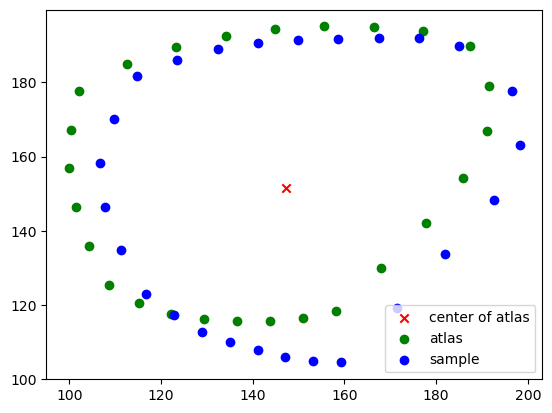

In [2]:
# Real data
anatomy = 'heart'
anatomy_idx = JSRTDataset.get_anatomical_structure_index()[anatomy]
shapes = (TRAINING_SHAPES[:, anatomy_idx[0]:anatomy_idx[1]] + 1) / 2 * 256

idx = 0
sample = shapes[idx]
atlas = shapes.mean(0)
del shapes

_, _, _, seg_mask = JSRTDataset('train')[idx]
seg_mask = seg_mask[list(JSRTDataset.get_anatomical_structure_index().keys()).index(anatomy)].bool()
center_of_mass = sample.mean(0).unsqueeze(0) #seg_mask.nonzero().flip(-1).float().mean(0, keepdim=True)

plt.scatter(center_of_mass[:, 0], center_of_mass[:, 1], c='r', marker='x', label='center of atlas')
plt.scatter(atlas[:, 0], atlas[:, 1], c='g', label='atlas')
plt.scatter(sample[:, 0], sample[:, 1], c='b', label='sample')
plt.legend()

In [3]:
# bounding box
bb_min = torch.min(atlas, dim=0).values
bb_max = torch.max(atlas, dim=0).values
range_atlas = bb_max - bb_min
range_atlas_int = range_atlas.floor().int()

In [4]:
pts = atlas.clone()
pts_centered = pts - center_of_mass
l1 = pts_centered.abs().max(-1, keepdim=True).values
#values = (pts_centered / l1).t()

O = round(range_atlas.max().item() / 2)
offset = torch.linspace(1/O, 1, O)
pts = pts_centered.unsqueeze(0) * offset.view(O, 1, 1) + center_of_mass.unsqueeze(0)
pts = pts.view(-1, 2)
values = pts_centered.unsqueeze(0) * offset.view(O, 1, 1) / l1.unsqueeze(0)
values = values.view(-1, 2)

# for i in range(1, 20):
#     pts = torch.cat([pts, pts_centered * i/20+center_of_mass], dim=0)
#     values = torch.cat([values, (pts_centered * i/20/l1).t()], dim=1)

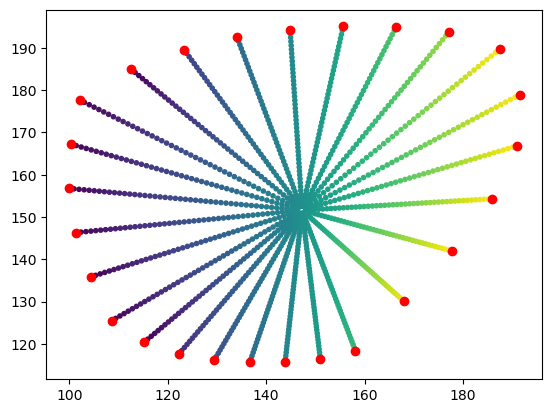

In [5]:
plt.scatter(pts[:, 0], pts[:, 1], c=values[:, 0], marker='.')
plt.scatter(atlas[:, 0], atlas[:, 1], c='r')

In [6]:
dist = torch.cdist(pts, atlas)
value_idx = torch.argmin(dist, dim=0)
atlas_pts_values = values[value_idx]
print(atlas_pts_values)

tensor([[-1.0000,  0.5767],
        [-1.0000,  0.3329],
        [-1.0000,  0.1091],
        [-1.0000, -0.1151],
        [-1.0000, -0.3669],
        [-1.0000, -0.6755],
        [-1.0000, -0.9724],
        [-0.7367, -1.0000],
        [-0.5038, -1.0000],
        [-0.2955, -1.0000],
        [-0.0958, -1.0000],
        [ 0.1058, -1.0000],
        [ 0.3264, -1.0000],
        [ 0.9616, -1.0000],
        [ 1.0000, -0.3166],
        [ 1.0000,  0.0698],
        [ 1.0000,  0.3481],
        [ 1.0000,  0.6179],
        [ 1.0000,  0.9478],
        [ 0.7088,  1.0000],
        [ 0.4414,  1.0000],
        [ 0.1925,  1.0000],
        [-0.0567,  1.0000],
        [-0.3230,  1.0000],
        [-0.6324,  1.0000],
        [-1.0000,  0.9597]])


In [7]:
print(pts_centered / l1, torch.eq(atlas_pts_values, atlas_pts_values).all())

tensor([[-1.0000,  0.5767],
        [-1.0000,  0.3329],
        [-1.0000,  0.1091],
        [-1.0000, -0.1151],
        [-1.0000, -0.3669],
        [-1.0000, -0.6755],
        [-1.0000, -0.9724],
        [-0.7367, -1.0000],
        [-0.5038, -1.0000],
        [-0.2955, -1.0000],
        [-0.0958, -1.0000],
        [ 0.1058, -1.0000],
        [ 0.3264, -1.0000],
        [ 0.9616, -1.0000],
        [ 1.0000, -0.3166],
        [ 1.0000,  0.0698],
        [ 1.0000,  0.3481],
        [ 1.0000,  0.6179],
        [ 1.0000,  0.9478],
        [ 0.7088,  1.0000],
        [ 0.4414,  1.0000],
        [ 0.1925,  1.0000],
        [-0.0567,  1.0000],
        [-0.3230,  1.0000],
        [-0.6324,  1.0000],
        [-1.0000,  0.9597]]) tensor(True)


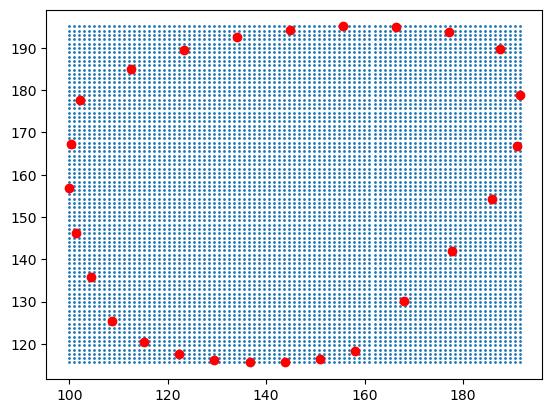

In [8]:
# range_sample_int = [25, 25]

# create grid for bounding box keeping the same amount of "pixel" as in the image
grid = torch.meshgrid(torch.linspace(bb_min[0], bb_max[0], range_atlas_int[0]), torch.linspace(bb_min[1], bb_max[1], range_atlas_int[1]), indexing='ij')
grid = torch.stack(grid, dim=-1).reshape(-1, 2)

plt.scatter(grid[:, 0], grid[:, 1], s=1)
plt.scatter(atlas[:, 0], atlas[:, 1], c='r')

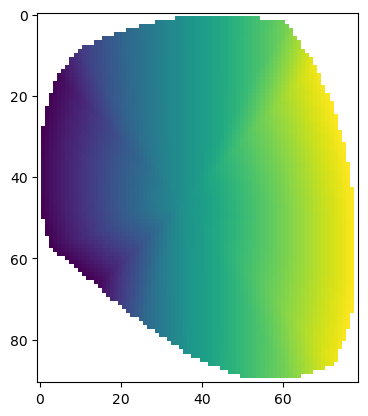

In [9]:
uv = griddata(pts, values, grid, method='linear', rescale=True)
uv = torch.from_numpy(uv)
uv = uv.reshape(range_atlas_int[0], range_atlas_int[1], 2).permute(2, 0, 1)

plt.imshow(uv[1])

In [10]:
import cv2
import numpy as np

def flow2img(flow, BGR=True):
	x, y = flow[0, 0,:,:], flow[0, 1, :, :]
	hsv = np.zeros((flow.shape[2], flow.shape[3], 3), dtype = np.uint8)
	ma, an = cv2.cartToPolar(x, y, angleInDegrees=True)
	hsv[..., 0] = (an / 2).astype(np.uint8)
	hsv[..., 1] = (cv2.normalize(ma * 52, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)).astype(np.uint8)
	hsv[..., 2] = 255
	img = []
	if BGR:
		img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
		return img
	else:
		img[0] = cv2.cvtColor(x, cv2.COLOR_HSV2RGB)
		img[1] = cv2.cvtColor(y, cv2.COLOR_HSV2RGB)
		return img

/tmp/ipykernel_4325/1197566685.py:8: RuntimeWarning: invalid value encountered in cast
  hsv[..., 0] = (an / 2).astype(np.uint8)
/tmp/ipykernel_4325/1197566685.py:9: RuntimeWarning: invalid value encountered in cast
  hsv[..., 1] = (cv2.normalize(ma * 52, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)).astype(np.uint8)


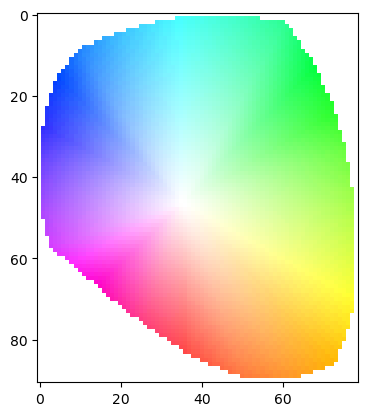

In [11]:
uv_plotting = flow2img(uv.unsqueeze(0).numpy())
plt.imshow(uv_plotting)

In [12]:
# bounding box
bb_min = torch.min(sample, dim=0).values
bb_max = torch.max(sample, dim=0).values
range_sample = bb_max - bb_min
range_sample_int = range_sample.round().int()

In [13]:
pts = sample.clone()
pts_centered = pts - sample.mean(0)
l1 = pts_centered.abs().max(-1, keepdim=True).values
#values = (pts_centered / l1).t()

O = round(range_sample_int.max().item() / 2)
offset = torch.linspace(1/O, 1, O)
pts = pts_centered.unsqueeze(0) * offset.view(O, 1, 1) + center_of_mass.unsqueeze(0)
pts = pts.view(-1, 2)
values = atlas_pts_values.unsqueeze(0) * offset.view(O, 1, 1)
values = values.view(-1, 2)

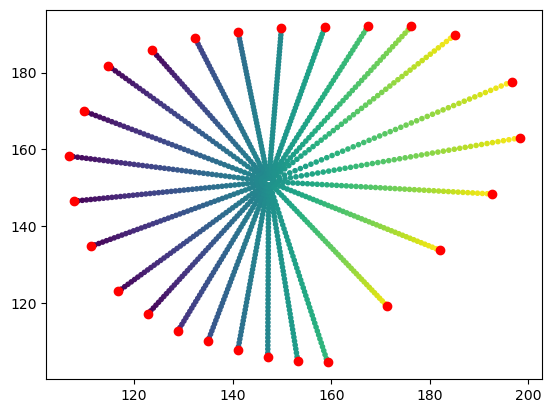

In [14]:
plt.scatter(pts[:, 0], pts[:, 1], c=values[:, 0], marker='.')
plt.scatter(sample[:, 0], sample[:, 1], c='r')

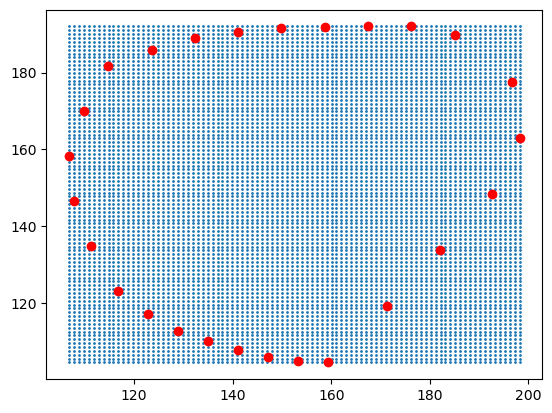

In [15]:
grid = torch.meshgrid(torch.linspace(bb_min[0], bb_max[0], range_sample_int[0]), torch.linspace(bb_min[1], bb_max[1], range_sample_int[1]), indexing='ij')
grid = torch.stack(grid, dim=-1).reshape(-1, 2)

plt.scatter(grid[:, 0], grid[:, 1], s=1)
plt.scatter(sample[:, 0], sample[:, 1], c='r')

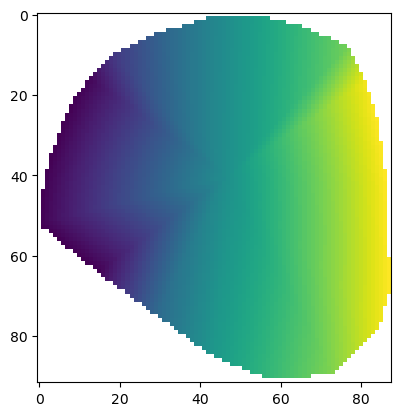

In [16]:
uv_sample = griddata(pts, values, grid, method='linear', rescale=True)
uv_sample = torch.from_numpy(uv_sample)
uv_sample = uv_sample.reshape(range_sample_int[0], range_sample_int[1], 2).permute(2, 0, 1)

plt.imshow(uv_sample[1])

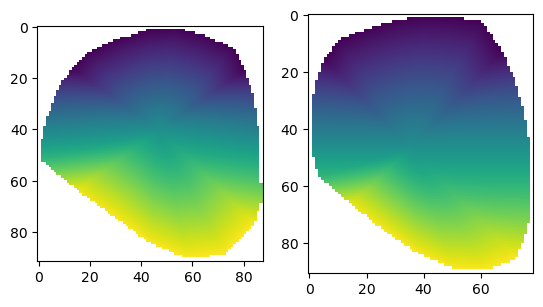

In [17]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(uv_sample[0])
axs[1].imshow(uv[0])

/tmp/ipykernel_4325/1197566685.py:8: RuntimeWarning: invalid value encountered in cast
  hsv[..., 0] = (an / 2).astype(np.uint8)
/tmp/ipykernel_4325/1197566685.py:9: RuntimeWarning: invalid value encountered in cast
  hsv[..., 1] = (cv2.normalize(ma * 52, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)).astype(np.uint8)


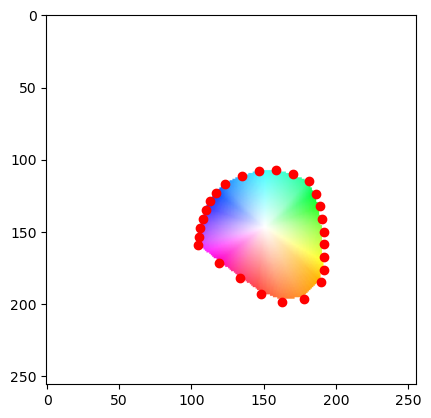

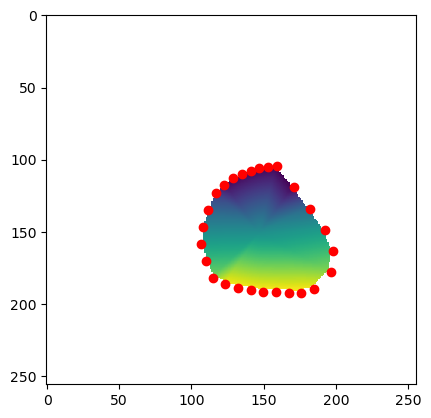

In [18]:
img_size = seg_mask.shape[::-1]
bb_max_int = bb_max.round().int() 
bb_min_int = bb_min.round().int()
uv_img_shape = bb_max_int - bb_min_int


uv_img_space = torch.full((2, img_size[0], img_size[1]), torch.nan)
uv_img_space[:, bb_min_int[0]:bb_max_int[0], bb_min_int[1]:bb_max_int[1]] = F.interpolate(uv_sample.unsqueeze(0), uv_img_shape.tolist(), mode='bilinear', align_corners=False).squeeze(0)
uv_img_space_masked = uv_img_space.clone().transpose(1, 2)
uv_img_space_masked[:, seg_mask.logical_not()] = torch.nan

uv_img_space_masked = uv_img_space_masked.flip(0)

uv_img_space_plotting = flow2img(uv_img_space.unsqueeze(0).numpy())
plt.imshow(uv_img_space_plotting)
plt.scatter(sample[:, 1], sample[:, 0], c='r')

plt.figure()
plt.imshow(uv_img_space_masked[0])
plt.scatter(sample[:, 0], sample[:, 1], c='r')